In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.linalg import pinv2
import time
from casadi import *


In [7]:
exp

<function casadi.casadi.exp(*args) -> 'double'>

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class ELM:
    def __init__(self, input_size, hidden_size = 10, output_size = 1):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.w = np.random.randn(hidden_size, input_size)
        self.beta = np.random.randn(output_size, hidden_size)        
        
    def update(self, x_new, y_new):
        x_new = np.array(x_new)
        y_new = np.array(y_new)
        
        y,h = self.forward(x_new)

        h_pinv = np.linalg.pinv(h)
        
        beta_est = y_new.dot(h_pinv)
        
        self.beta = beta_est
        
        return y, beta_est
        
        
    def forward(self, x):
        x = np.array(x)
        h = sigmoid(self.w.dot(x))

        y = self.beta.dot(h)
        
        return y, h
        
        

In [3]:
N = 100
t = np.linspace(-2.5,2.5,N)
xs = np.vstack([np.sin(0.1*t),np.sin(0.5*t),np.sin(2*t),np.sin(0.001*t)])

ys = np.expand_dims(t**5+0.1*t**2+0.3*t**3, axis = 0)

elm = ELM(4)

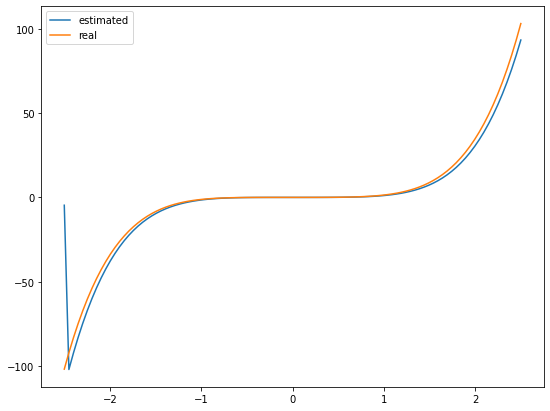

In [4]:
y_reals = []
y_ests = []

for i in range(N):
    x = xs[:,i:i+1]
    y_real = ys[:,i:i+1]
    
    y_est, _ = elm.update(x, y_real)
    
    y_reals.append(y_real)
    y_ests.append(y_est)
    
yrs = np.array(y_reals).squeeze()
yes = np.array(y_ests).squeeze()

f,ax = plt.subplots(1,1, figsize = (9,7))

ax.plot(t, yes)
ax.plot(t, yrs)
ax.legend(['estimated','real'])
    

In [90]:
class OSELM:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
                
        self.w_ik = 1*np.random.randn(input_dim,hidden_dim)
        self.P = np.zeros((self.hidden_dim, self.hidden_dim))
        self.Omega = np.zeros((self.hidden_dim, self.output_dim))
        

    def predict(self, x, u_num, data_points = 1):
        xe = np.hstack([x, u_num])
        
        H = []

        for n in range(data_points):   
            h = []
            for k in range(self.hidden_dim):
                g = []
                for i in range(self.input_dim):
                    g.append(xe[n,i]* self.w_ik[i,k])
                g = sigmoid(np.sum(g))
                h.append(g) 
            h = np.array(h)
            H.append(h)

        H = np.array(H)
        
        y = np.matmul(H, self.Omega)
        
        return y, H
        
    def predict_casadi(self,x, u):
        def sigmoid_casadi(x):
            return 1 / (1 + casadi.exp(-x))
        y = 0 
        #print("TTTTTTTTTTT")
        for k in range(self.hidden_dim):
            g = 0
            for i in range(self.input_dim):
                if i == (self.input_dim - 1):
                    g += u* self.w_ik[i,k]
                else:
                    g += (x[0,i]* self.w_ik[i,k])
            #print(g)
            
            g = sigmoid_casadi(g)
            y += self.Omega[k,0]*g
        #print("RRRRRRRR")
        #print(self.Omega)
        #print("SSSSSSSSSSSS")
        return y        
        
    def training_first(self, xs, us_num, ys):
        
        if xs.ndim > 2:
            xs = xs.squeeze()
        
        data_points, _ = np.shape(xs)
        
        _, H = self.predict(xs, us_num, data_points)
                
        # Calculate P0 and T0
        self.P = pinv2(np.matmul(H.T, H))
       
        self.Omega = np.matmul(self.P, np.matmul(H.T, ys))

    def training(self,x, u_num, y):

        
        _, H = self.predict(x, u_num)
        #print("tttttt")
        #print("H")
        #print(type(H))
        #print("P")
        #print(type(self.P))
        #print("y")
        #print(y)
        #print(1)
        self.P = self.P - np.matmul(self.P, np.matmul(H.T, np.matmul(H, self.P))) / (1 + (np.matmul(H, np.matmul(self.P,H.T))))
        #print(self.Omega)
        self.Omega = self.Omega + np.matmul( self.P, np.matmul(H.T, y - np.matmul(H, self.Omega)))
        #print(2)
        #print(self.Omega)
        
        
        #print(x)
        #print(u_num)
        #print("ffffff")

    def get_P(self):
        return self.P
    
    def get_Omega(self):
        return self.Omega
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [80]:
class OSELM:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
                
        self.w_ik = 1*np.random.randn(I,K)
        self.P = np.zeros((self.hidden_dim, self.hidden_dim))
        self.Omega = np.zeros((self.hidden_dim, self.output_dim))
        

    def predict(self, x, u_num, data_points = 1):
        """"
        x: (classes, x_dim )
        u_num: (classes, u_num_dim )
        
        y: (classes, output_dim)
        """
        

        xe = np.hstack([x, u_num])
        
        H = []

        for n in range(data_points):   
            h = []
            for k in range(self.hidden_dim):
                g = []
                for i in range(self.input_dim):
                    g.append(xe[n,i]* self.w_ik[i,k])
                g = sigmoid(np.sum(g))
                h.append(g) 
            h = np.array(h)
            H.append(h)

        H = np.array(H)
        
        #print(H.shape)
        
        #print(self.Omega.shape)
        
        y = np.matmul(H, self.Omega)

        return y, H
        
    def predict_casadi(self,x, u):
        #print("#0")
        #print(x.shape)
             
        
        def sigmoid_casadi(x):
            return 1 / (1 + exp(-x))
 
        y = 0 
        for k in range(self.hidden_dim):
            g = 0
            for i in range(self.input_dim):
                if i == (self.input_dim - 1):
                    g += u[0,0]* self.w_ik[i,k]
                else:
                    g += (x[0,i]* self.w_ik[i,k])
            g = sigmoid_casadi(g)
            print(g[0])
            y = y + self.Omega[k,0]*g[0]

        return y        
        
    def training_first(self, xs, us_num, ys):
        #print("#1")
        #print(xs.shape)
        #print(us_num.shape)
        
        data_points, _ = np.shape(xs)
        
        _, H = self.predict(xs, us_num, data_points)
                
        # Calculate P0 and T0
        self.P = pinv2(np.matmul(H.T, H))

        # Calculate initial weight matrix
        self.Omega = np.matmul(self.P, np.matmul(H.T, ys))
        
    def training(self,x, u_num, y):
        #print("#2")
        #print(x.shape)
        #print(u_num.shape)
        
        _, H = self.predict(x, u_num)
        
        #print(H.shape)
        #print(self.P.shape)
        
        np.matmul(H, self.P)
        
        np.matmul(self.P, np.matmul(H.T, np.matmul(H, self.P)))
        
        (1 + (np.matmul(H, np.matmul(self.P,H.T))))
        
        self.P = self.P - np.matmul(self.P, np.matmul(H.T, np.matmul(H, self.P))) / (1 + (np.matmul(H, np.matmul(self.P,H.T))))
        self.Omega = self.Omega + np.matmul( self.P, np.matmul(H.T, y - np.matmul(H, self.Omega)))

    def get_P(self):
        return self.P
    
    def get_Omega(self):
        return self.Omega
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [12]:
def multiply(v, G):
    result = []
    for i in range(len(G[0])): #this loops through columns of the matrix
        total = 0
        for j in range(len(v)): #this loops through vector coordinates & rows of matrix
            total += v[j] * G[j][i]
        result.append(total)
    return result

In [91]:
I = 6 #input_size
K = 100 # hidden_size
L = 1 # output_size

N0 = int(1.2*K)

M = 1000

elm = OSELM(I,K,L)




def system_update(t = None):
    if not t:
        t = np.array([np.random.uniform(-2.5, 2.5)])
    #t = np.linspace(-2.5,2.5,M+N0)
    x = np.vstack([1, np.sin(0.1*t),np.sin(0.5*t),np.sin(5*t),np.sin(t)])
    
    u = np.vstack([np.sin(0.1*t)])
    
    y = np.expand_dims(0.3*np.sin(4*t)-0.2*t**2-2, axis = 0) # t**5+0.1*t**2+0.3*t**3
    
    s = [t]
    return x, u, y, s

samples_x = []
samples_u = []
samples_t = []
samples_s = []

for n in range(N0):
    x, u, t, s = system_update()
    samples_x.append(x)
    samples_u.append(u)
    samples_t.append(t)
    samples_s.append(s)

samples_x = np.array(samples_x)[:,:,0]
samples_u = np.array(samples_u)[:,:,0]
samples_t = np.array(samples_t)[:,:,0]

elm.training_first(samples_x , samples_u , samples_t )

pbar = tqdm(total=M)


xs = []
ys = []
ts = []
ss = []
ors = []
times = []
for m in range(M):
    pbar.update(n=1)
    x, u_num, t, s = system_update()#tlns[m])
    
    u = SX.sym('u')
    
    #print(x.shape)
    #elm.predict_casadi(x.T, u.T)
    
    
    start = time.time()
    
    #print(x.shape)
    #print(u_num.shape)
    
    y, _ = elm.predict(x.T, u_num.T)
    
    elm.training(x.T, u_num.T, t)
    
    times.append(time.time()-start)
    
    start = time.time()

    times.append(time.time()-start)
    
    ors.append(np.linalg.norm(elm.get_Omega()))
    
    if m>0:#.7*M:
        xs.append(x)
        ys.append(np.squeeze(y))
        ts.append(t)
        ss.append(s)











  0%|          | 0/1000 [00:00<?, ?it/s]








  1%|          | 7/1000 [00:00<00:15, 64.46it/s]








  2%|▏         | 15/1000 [00:00<00:13, 72.90it/s]








  2%|▏         | 23/1000 [00:00<00:13, 74.15it/s]








  3%|▎         | 31/1000 [00:00<00:16, 58.92it/s]








  4%|▍         | 38/1000 [00:00<00:19, 48.35it/s]








  5%|▍         | 46/1000 [00:00<00:17, 53.71it/s]








  5%|▌         | 52/1000 [00:00<00:18, 52.45it/s]








  6%|▌         | 58/1000 [00:01<00:19, 48.62it/s]








  7%|▋         | 67/1000 [00:01<00:16, 57.49it/s]








  7%|▋         | 74/1000 [00:01<00:15, 59.43it/s]








  8%|▊         | 84/1000 [00:01<00:13, 68.97it/s]








  9%|▉         | 92/1000 [00:01<00:14, 60.77it/s]








 10%|█         | 100/1000 [00:01<00:13, 64.32it/s]








 11%|█         | 107/1000 [00:01<00:13, 64.72it/s]








 11%|█▏        | 114/1000 [00:01<00:15, 58.20it/s]








 12%|█▏        | 124/1000 [00:02<00:12, 68.53it/s]








 14%|█▎    

(120, 1)

In [33]:
I = 5 #input_size
K = 100 # hidden_size
L = 1 # output_size

B = 3  # Basis function

N0 = int(1.2*K*B)
M = 1000

def system_update(t = None):
    if not t:
        t = np.random.uniform(-2.5, 2.5)
    #t = np.linspace(-2.5,2.5,M+N0)
    x = np.vstack([1, np.sin(0.1*t),np.sin(0.5*t),np.sin(5*t),np.sin(t)])
    
    y = np.expand_dims(0.3*np.sin(4*t)-0.2*t**2-2, axis = 0) # t**5+0.1*t**2+0.3*t**3
    s = t
    return x, y, s



# Random Generate weight and select basis

w_ik = 1*np.random.randn(I,K)

def basis(n, b, dT = 0.05):
    n = n*dT
    if b == 0:
        f = 1
    elif b == 1:
        f = 1 # - 2*n / B
    elif b == 2:
        f = 1 #- 6*n / B  + 6 * n * (n-1) / B / (B-1) # n**2/2#2*n**2 - 1 # 0.5*(3*n**2-1)
    else:
        raise Exception('b is higher than expected')
    return f

# Accumulate N0 samples of training data
#N0 = int(1.8*K*B)

samples_x = []
samples_t = []
samples_s = []

for n in range(N0):
    x, t, s = system_update()
    samples_x.append(x)
    samples_t.append(t)
    samples_s.append(s)

samples_x = np.array(samples_x)
samples_t = np.array(samples_t)
    
# Calculate the time invariant hidden layer
H = []

for n in range(N0):   
    h = []
    for k in range(K):
        g = []
        for i in range(I):
            g.append(samples_x[n,i]* w_ik[i,k])
        g = sigmoid(np.sum(g)) # np.sum(g) #np.minimum(0, np.sum(g))# np.tanh(np.sum(g)) #sigmoid(np.sum(g))# 
        h.append(g) 

    h = np.array(h)#np.expand_dims(np.array(h), axis=0)
    
    H.append(h)
    
H = np.array(H)
    
# Calculate P0 and T0
P0 = pinv2(np.matmul(H.T, H)) # G0.T.dot(G0)

#print(P0)
#dadas

T0 = samples_t

# Calculate initial weight matrix
Omega0 = np.matmul(P0, np.matmul(H.T, T0)) # P0.dot(G0.T.dot(T0))

Pm = P0
Omegam = Omega0

#print(Pm.shape) # 150x150 : KBxKB
#print(Omegam.shape) # 150x1 : KBxL

xs = []
ys = []
ts = []
ss = []
os = []

tlns = np.linspace(-2.5,2.5,M)

pbar = tqdm(total=M)

times = []
for m in range(M):
    pbar.update(n=1)
    x, t, s = system_update()#tlns[m])
    
      
    h = []
    for k in range(K):
        g = []
        for i in range(I):
            g.append(x[i] * w_ik[i,k])
        g = sigmoid(np.sum(g)) # np.sum(g) #np.minimum(0, np.sum(g))# np.tanh(np.sum(g)) #sigmoid(np.sum(g))# 
        h.append(g) 

    h = np.array(h)#np.expand_dims(np.array(h), axis=0)

    h = np.expand_dims(h, axis = 1)
    #print(h.T.shape)
    
    start = time.time()
    
    #print(Pm.shape)
    y = np.matmul(h.T,Omegam)
    #print(Pm)
    
    Pm = Pm - np.matmul(Pm, np.matmul(h, np.matmul(h.T, Pm))) / (1 + (np.matmul(h.T, np.matmul(Pm,h))))    # Pm*g.dot(g.T)*(Pm)/(1 + (g.T*Pm).dot(g))
    #print(Pm)
    Omegam = Omegam + np.matmul( Pm, np.matmul(h, t - np.matmul(h.T, Omegam))) #*g.dot(t-g.T.dot(Omegam))
    
    times.append(time.time()-start)
    
    #os.append(np.linalg.norm(Omegam))
    
    #print(h.T.shape)
    #print(Omegam.shape)
    #print(y.shape)
    
    if m>0:#.7*M:
        xs.append(x)
        ys.append(np.squeeze(y))
        ts.append(t)
        ss.append(s)
pbar.close()






  0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 5/1000 [00:00<00:20, 48.17it/s]


  1%|          | 11/1000 [00:00<00:19, 51.62it/s]


  2%|▏         | 17/1000 [00:00<00:18, 52.52it/s]


  2%|▏         | 23/1000 [00:00<00:18, 53.34it/s]


  3%|▎         | 29/1000 [00:00<00:19, 48.59it/s]


  3%|▎         | 34/1000 [00:00<00:20, 46.53it/s]


  4%|▍         | 39/1000 [00:00<00:20, 46.28it/s]


  5%|▍         | 46/1000 [00:00<00:18, 52.71it/s]


  5%|▌         | 52/1000 [00:01<00:18, 51.61it/s]


  6%|▌         | 59/1000 [00:01<00:16, 56.44it/s]


  7%|▋         | 68/1000 [00:01<00:14, 65.00it/s]


  8%|▊         | 75/1000 [00:01<00:16, 57.23it/s]


  9%|▊         | 86/1000 [00:01<00:13, 70.03it/s]


 10%|▉         | 97/1000 [00:01<00:11, 79.70it/s]


 11%|█         | 106/1000 [00:01<00:11, 80.12it/s]


 12%|█▏        | 115/1000 [00:01<00:11, 80.08it/s]


 12%|█▏        | 124/1000 [00:01<00:10, 80.32it/s]


 13%|█▎        | 133/1000 [00:02<00:12, 69.35it/s]


 14%|█▍        

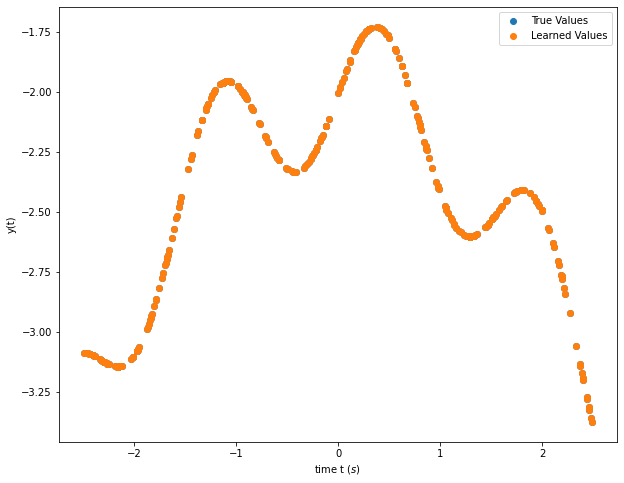

In [92]:
plt.figure(figsize = (10,8))

bottom = int(0.7*M)

plt.scatter(ss[bottom:-1], ts[bottom:-1])
    
plt.scatter(ss[bottom:-1], ys[bottom:-1])

plt.xlabel('time t ($s$)')
plt.ylabel('y(t)')


plt.legend(['True Values','Learned Values'])

#plt.ylim([-4, 0])

In [39]:
ys = []

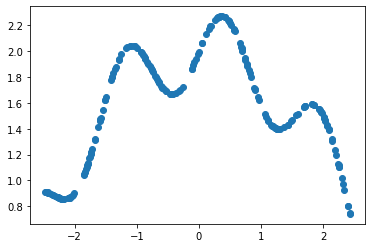

In [131]:
plt.scatter(samples_s, samples_t)

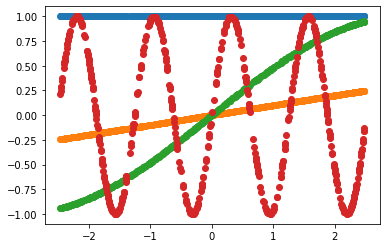

In [18]:
plt.scatter(samples_s, samples_x[:,0])
plt.scatter(samples_s, samples_x[:,1])
plt.scatter(samples_s, samples_x[:,2])
plt.scatter(samples_s, samples_x[:,3])

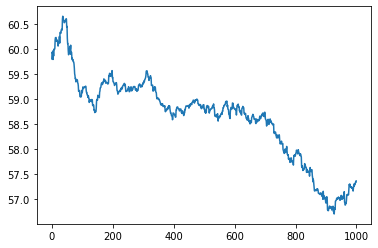

In [48]:
plt.plot(os)

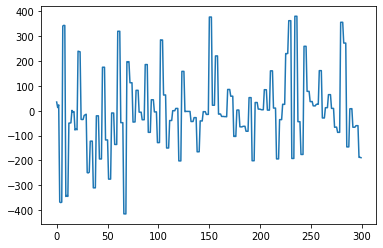

In [146]:
plt.plot(Omegam)